In [1]:
from clawpack import pyclaw
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from __future__ import absolute_import
from clawpack import riemann
#from clawpack.riemann.shallow_roe_with_efix_1D_constants import depth, momentum, num_eqn

In [2]:
def sigmoid(x):
    p = np.multiply(-1,x)
    vals = 1/(1+np.power(np.e,p))
    return vals
sigmoid([0,1,2])

array([ 0.5       ,  0.73105858,  0.88079708])

In [3]:
def entropycalc(h,u,num_ghost):
    #pass in h-b to adjust for topography
    # I think I need to pass from custom bc
    #ghost = h[:num_ghost] + h[-num_ghost:]
    #ughost = u[:num_ghost] + u[-num_ghost:]#remove BC values
    hfixed = h[num_ghost:-num_ghost]
    ufixed = u[num_ghost:-num_ghost] # Removing the ghost cells
    currentEntropyArray =  np.add( hfixed,np.multiply(ufixed,ufixed) ) #- hghost - ughost
    summedE = np.sum(currentEntropyArray)
    global entropies
    global fullE
    global hss
    global uss
    hss = hss + [hfixed]
    uss = uss + [ufixed]
    #fullE = fullE + [currentEntropyArray]
    entropies = entropies + [summedE]
    #look at two different states and subtract for flux?
    
    #fornberg algorithm for finite differences method take coeffs from result. might be in matlab
    # banks fornberg

In [4]:
 def custom_bc(state,dim,t,qbc,num_ghost):
    qbc[0,0] = in_height
    qbc[0,1] = in_height
    qbc[-1,0] = 0
    qbc[-2,0] = 0
    
    #qbc[0,:num_ghost] = qbc[]

    qbc[1,0] = in_velocity
    qbc[1,1] = in_velocity
    qbc[1,-1] = qbc[1,-3]
    qbc[1,-2] = qbc[1,-3]
    entropycalc(qbc[0,:],qbc[1,:],num_ghost)

In [5]:
def runclaw(in_height,in_velocity,xlower,xupper):
    claw = pyclaw.Controller()
    claw.tfinal = 300.0
    claw.keep_copy = True
    claw.output_format = None
    claw.num_output_times = 60
    #rs = riemann.shallow_roe_with_efix_1D
    rs = riemann.shallow_1D_py.shallow_fwave_1d

    num_eqn = 2
    solver = pyclaw.ClawSolver1D(rs)
    solver.order = 2
    solver.num_ghost = 2
    solver.num_waves=2
    solver.num_eqn=2
    #solver.limiters = pyclaw.limiters.tvd.minmod
    #solver.limiters = pyclaw.limiters.tvd.vanleer

    solver.kernel_language = 'Python'

    #solver.all_bcs = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.bc_lower[0] = pyclaw.BC.custom
    #solver.bc_upper[0] = pyclaw.BC.custom
    solver.user_bc_lower = custom_bc

    #print(solver.bc_lower)
    solver.aux_bc_lower[0] = pyclaw.BC.extrap
    solver.aux_bc_upper[0] = pyclaw.BC.extrap


    #solver.all_bcs = pyclaw.BC.periodic

    #xlower = -2.0
    #xupper = 50.0
    mx = 800
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    state = pyclaw.State(domain,num_eqn,1)

    state.problem_data['grav'] = 1.0
    state.problem_data['sea_level'] = 0.0
    state.problem_data['dry_tolerance'] = 0.1

    xc = state.grid.x.centers
    x0=0.0


    #state.q[0,:] = hl * (xc <= x0) + hr * (xc > x0) #+ hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[0,:] = 3
    state.q[0,:] = in_height# - ((in_height/1.5)*(xc>=x0+10))  #+(1 * (xc<x0)+ (1 - xc/1) * (xc>= x0) * (xc < 1) )
    #state.q[0,:] =  in_height + (0.5 * (xc<x0)+ (0.5 - xc/10) * (xc>= x0) * (xc < 5)) -0.5
    state.q[1,:] = in_velocity #+ 0.5*(xc>= x0) - 0.25*(xc>= x0+15)   #ul * (xc <= x0) + ur * (xc > x0)

    #state.aux[0, :] = 1.0 * np.exp(-xc**2 / 0.2**2) - 1.0
    #state.aux[0,:] = sigmoid(np.multiply(-1,xc))/4
    #else:
    state.aux[0, :] = 0.5 * (xc<x0)+ (0.5 - xc/2) * (xc>= x0) * (xc < 1) #low slope IC
    #state.aux[0, :] = 1 * (xc<x0)+ (1 - xc/10) * (xc>= x0) * (xc < 10) #higher slope IC
    #state.aux[0,:] = 0.5* (xc<x0)  #step IC

    #state.aux[0,:] = 0

    #state.q[0,:] = hl * (xc <= x0 - obj_size) + hr * (xc > x0+obj_size) + hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[1,:] = hl*ul * (xc <= x0) + hr*ur * (xc > x0)

    plt.plot(xc,state.q[0,:])
    plt.plot(xc,state.aux[0,:])
    plt.plot(xc,state.q[1,:])

    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.run()
    return [claw.frames,xc]

In [6]:
#plt.plot(xc,state.q[0,:])
#plt.plot(xc,state.aux[0,:])
#plt.plot(xc,state.q[1,:])

In [7]:
#claw.solution = pyclaw.Solution(state,domain)
#claw.solver = solver
#claw.run()

2019-03-14 16:39:23,463 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-14 16:39:23,468 INFO CLAW: Solution 0 computed for time t=0.000000


/home/max/anaconda3/lib/python3.6/site-packages/clawpack/riemann/shallow_1D_py.py:206: RuntimeWarning: divide by zero encountered in true_divide
  q_l[1,:] / q_l[0,:], 0.0)


2019-03-14 16:39:23,942 INFO CLAW: Solution 1 computed for time t=5.000000
2019-03-14 16:39:24,399 INFO CLAW: Solution 2 computed for time t=10.000000
2019-03-14 16:39:24,863 INFO CLAW: Solution 3 computed for time t=15.000000
2019-03-14 16:39:25,329 INFO CLAW: Solution 4 computed for time t=20.000000
2019-03-14 16:39:25,801 INFO CLAW: Solution 5 computed for time t=25.000000
2019-03-14 16:39:26,282 INFO CLAW: Solution 6 computed for time t=30.000000
2019-03-14 16:39:26,763 INFO CLAW: Solution 7 computed for time t=35.000000
2019-03-14 16:39:27,251 INFO CLAW: Solution 8 computed for time t=40.000000
2019-03-14 16:39:27,744 INFO CLAW: Solution 9 computed for time t=45.000000
2019-03-14 16:39:28,244 INFO CLAW: Solution 10 computed for time t=50.000000
2019-03-14 16:39:28,750 INFO CLAW: Solution 11 computed for time t=55.000000
2019-03-14 16:39:29,263 INFO CLAW: Solution 12 computed for time t=60.000000
2019-03-14 16:39:29,782 INFO CLAW: Solution 13 computed for time t=65.000000
2019-03-1

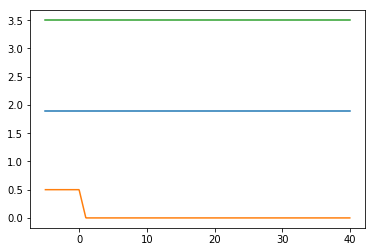

In [8]:
#from clawpack.visclaw import ianimate
#ianimate.ianimate(claw)

#testframe = claw.frames[50]
#testframe2 = claw.frames[1]
#np.mean(testframe.q[0,:]-testframe2.q[0,:])
in_height = 1.9
in_velocity = 3.5
xlower = -5
xupper = 40
entropies = []
fullE = []
hss = []
uss = []
solns,xc = runclaw(in_height, in_velocity, xlower, xupper)

In [9]:
#in_height = 1.75
#in_velocity = 2
#solns = runclaw(in_height, in_velocity)
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

frame = solns[0]
depth = frame.q[0,:]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
plt.legend(['Fluid height','Fluid velocity', 'Topography'])
plt.xlabel('X')
plt.ylabel('h, u, b')
ax.set_xlim(xlower,xupper)
ax.set_ylim(-5,5)
def fplot(frame_number):
    frame = solns[frame_number]
    depth = frame.q[0,:]
    velocity = frame.q[1,:]
    b = frame.aux[0,:]
    line1.set_data(xc,depth)
    line2.set_data(xc,velocity)
    line3.set_data(xc,b)
    return line1,

anim = animation.FuncAnimation(fig, fplot, frames=len(solns), interval=50, repeat=False) #len(claw.frames) can be put in frames=
plt.close()
HTML(anim.to_jshtml())

In [10]:
test = solns[15]
test.q[0,:]

array([ 1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9       ,
        1.9       ,  1.9       ,  1.9       ,  1.9       ,  1.9 

In [11]:
xc

array([ -4.97187500e+00,  -4.91562500e+00,  -4.85937500e+00,
        -4.80312500e+00,  -4.74687500e+00,  -4.69062500e+00,
        -4.63437500e+00,  -4.57812500e+00,  -4.52187500e+00,
        -4.46562500e+00,  -4.40937500e+00,  -4.35312500e+00,
        -4.29687500e+00,  -4.24062500e+00,  -4.18437500e+00,
        -4.12812500e+00,  -4.07187500e+00,  -4.01562500e+00,
        -3.95937500e+00,  -3.90312500e+00,  -3.84687500e+00,
        -3.79062500e+00,  -3.73437500e+00,  -3.67812500e+00,
        -3.62187500e+00,  -3.56562500e+00,  -3.50937500e+00,
        -3.45312500e+00,  -3.39687500e+00,  -3.34062500e+00,
        -3.28437500e+00,  -3.22812500e+00,  -3.17187500e+00,
        -3.11562500e+00,  -3.05937500e+00,  -3.00312500e+00,
        -2.94687500e+00,  -2.89062500e+00,  -2.83437500e+00,
        -2.77812500e+00,  -2.72187500e+00,  -2.66562500e+00,
        -2.60937500e+00,  -2.55312500e+00,  -2.49687500e+00,
        -2.44062500e+00,  -2.38437500e+00,  -2.32812500e+00,
        -2.27187500e+00,

In [12]:
entropies[-5:-1]
#c(1/2 dh/dt u^2 + h u du/dt + 2gh dh/dt)

[11074.525196164763,
 11074.525196164763,
 11074.525196164763,
 11074.525196164763]

In [35]:
print(hss[100])

[ 1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.9         1.9
  1.9         1.9         1.9         1.9         1.9         1.